In [1]:
import os; os.environ['CUDA_VISIBLE_DEVICES']='7'

# Lesson 1 - What's your pet

Welcome to lesson 1! For those of you who are using a Jupyter Notebook for the first time, you can learn about this useful tool in a tutorial we prepared specially for you; click `File`->`Open` now and click `00_notebook_tutorial.ipynb`. 

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results. Let's dive in!

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

Lesson 1 에 오신 걸 환영합니다.
Jupyter Notebook을 처음 사용 하는 분들을 위해서 튜토리얼을 준비했습니다. `00_notebook_tutorial.ipynb` 에서 확인하실 수 있습니다.

이번 lesson 에서는 이미지 분류기를 제작해 볼 것입니다.

모든 notebook은 아래의 3라인의 코드로 시작합니다. 해당 코드는 라이브러리가 변화가 있으면 자동으로 리로딩하고 또한 차트나 이미지를 notebook 안에서 출력하도록 해줍니다.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

모든 필요한 패키지들을 import 해줍니다.
이 수업은 Pytorch 1.0 버전 위에 구현된 fastai V1 라이브러리를 가지고 진행합니다.
fastai 는 빠르고 쉽게 뉴럴 네트워크를 구축하고 학습시킬 수 있도록 많은 유용한 기능들을 제공하고 있습니다.

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

만약 여러분이 작은 GPU를 가진 컴퓨터를 사용 중이라면, 아마도 이 notebook를 실행하다가 Out of Memory 에러를 맞딱뜨리게 될 것입니다.
만약 그런 일이 생긴다면 `Kernel->Restart` 를 누르시고, 아래 2번째 라인을 주석해제 하세요.(이게 어떤걸 의미하는지는 추후에 배우게 됩니다.) 그리고 처음부터 다시 시도하세요.

In [3]:
bs = 32
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

우리는 [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) 논문의 [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/)를 사용할 겁니다. 이것은 12종의 고양이와 25종의 강아지에 대한 이미지 데이터입니다.
우리의 모델은 37 종의 애완동물 간의 다른점을 학습해야 합니다. 저 논문에 의하면 2012년 당시 최고 정확도는 59.21%였습니다. 이 과정에서 복잡한 모델이 사용되었는데, 애완동물 사진을 전체이미지, 머리, 몸을 나누고 분류하도록 했었습니다. 

우리는 `untar_data` 를 사용할 것입니다. 우리가 이 function에 URL을 인수로 넘기면 해당 URL의 파일을 다운받고 데이터를 압축해제 합니다.

In [4]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url: str, fname: Union[pathlib.Path, str] = None, dest: Union[pathlib.Path, str] = None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if it doesn't exist, and un-tgz to folder `dest`.



In [5]:
??URLs

In [4]:
path = untar_data(URLs.PETS,dest='data'); path

WindowsPath('data/oxford-iiit-pet')

In [5]:
path.ls()

[WindowsPath('data/oxford-iiit-pet/annotations'),
 WindowsPath('data/oxford-iiit-pet/images')]

In [6]:
path_anno = path/'annotations'
path_img = path/'images'

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

문제에 접근할 때 우리가 먼저 할 일은 데이터를 살펴보는 것입니다. 우리는 항상 문제가 무엇인지 그리고 어떻게 해결할지 생각하기에 앞서 데이터가 어떻게 생겼는지를 매우 잘 파악할 필요가 있습니다.
데이터를 살펴본다는 것은 데이터 디렉토리가 어떻게 구성되어 있는지, 즉 label은 어떻게 되어있는지 그리고 몇몇 샘플 이미지는 어떻게 되어 있는지 등을 이해하는 것을 의미합니다.

이미지 분류 데이터셋을 다룰때 주요 차이점은 label이 표현되어 있는 방식입니다. 
이번 데이터셋은 label이 파일명에 포함되어 있습니다. 우리는 올바른 카테고리로 분류할 수 있도록 label들을 추출해야 합니다. 다행히 fastai 라이브러리는 이것을 해결할 수 있는 function이 있습니다. `ImageDataBunch.from_name_re` 은 정규식을 활용하여 파일명으로부터 label을 꺼낼 수 있도록 합니다.

In [7]:
fnames = get_image_files(path_img)
fnames[:5]

[WindowsPath('data/oxford-iiit-pet/images/Abyssinian_1.jpg'),
 WindowsPath('data/oxford-iiit-pet/images/Abyssinian_10.jpg'),
 WindowsPath('data/oxford-iiit-pet/images/Abyssinian_100.jpg'),
 WindowsPath('data/oxford-iiit-pet/images/Abyssinian_101.jpg'),
 WindowsPath('data/oxford-iiit-pet/images/Abyssinian_102.jpg')]

In [9]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [11]:
??imagenet_stats

In [10]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

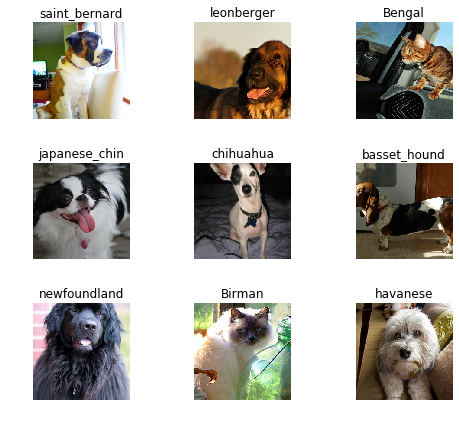

In [13]:
data.show_batch(rows=3, figsize=(7,6))

In [16]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

이제 모델을 훈련시킬 차례입니다.
우리는 [콘볼루션 신경망](http://cs231n.github.io/convolutional-networks/) backbone과 하나의 hidden layer을 가진 fully connected head를 분류기로 사용할 것입니다. 이게 당장 무슨 뜻인지 모르지만, 앞으로 차차 알아나갈 것이니 걱정하지 마세요.
중요한 건 우리가 이미지를 입력하고, 이에 대한 각 카테고리별 예측 확률을 출력하는 모델을 제작 중이라는 것입니다.(이 경우 37개의 출력이 있음).

우리는 4 epoch(모든 데이터를 4 사이클 순환) 동안 훈련할 것입니다.

In [14]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [18]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [19]:
learn.fit_one_cycle(4)

In [19]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

결과가 어떤지 확인해 보겠습니다.

우리는 먼저 모델이 서로 가장 혼동되는 카테고리가 무엇이었는지 볼 것입니다. 우리는 그 모델이 예측한 것이 타당한지 아닌지 알아보려고 합니다. 이 경우에 실수는 합리적으로 보입니다. 이것은 우리 분류기가 올바르게 작동하고 있다는 지표로 볼 수 있습니다.

더욱이, confusion matrix 를 그려봤을때, 우리는 분포가 심하게 왜곡되어 있음을 알 수 있다. 즉, 모델은 같은 실수를 반복하지만 다른 범주를 혼돈시키는 경우는 거의 없다. 이것은 단지 서로간의 특정 범주를 구별하는 것이 어렵다는 것을 시사한다; 이것은 정상적인 행동이다.

In [20]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

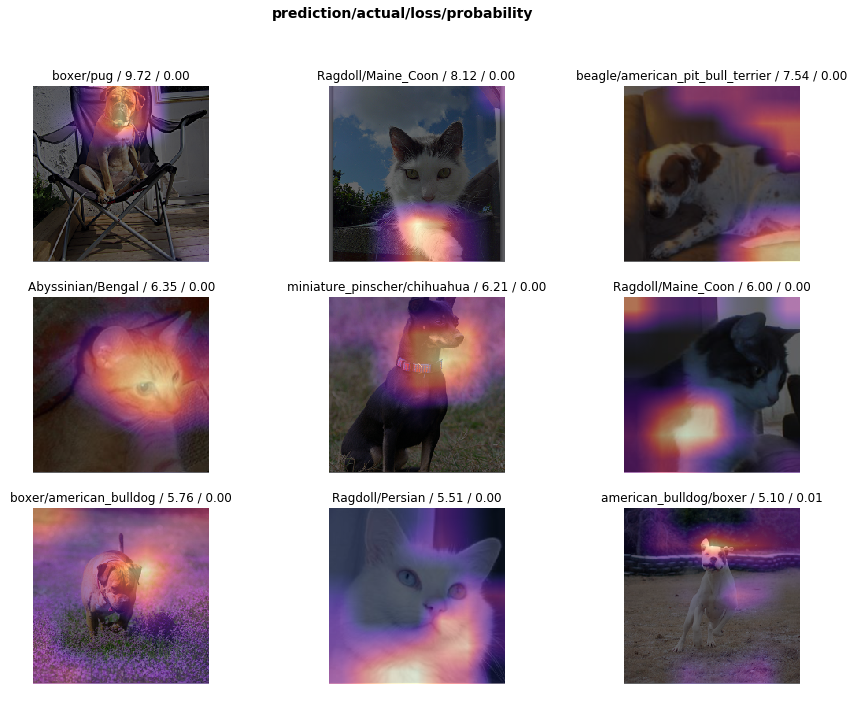

In [21]:
interp.plot_top_losses(9, figsize=(15,11))

In [22]:
doc(interp.plot_top_losses)

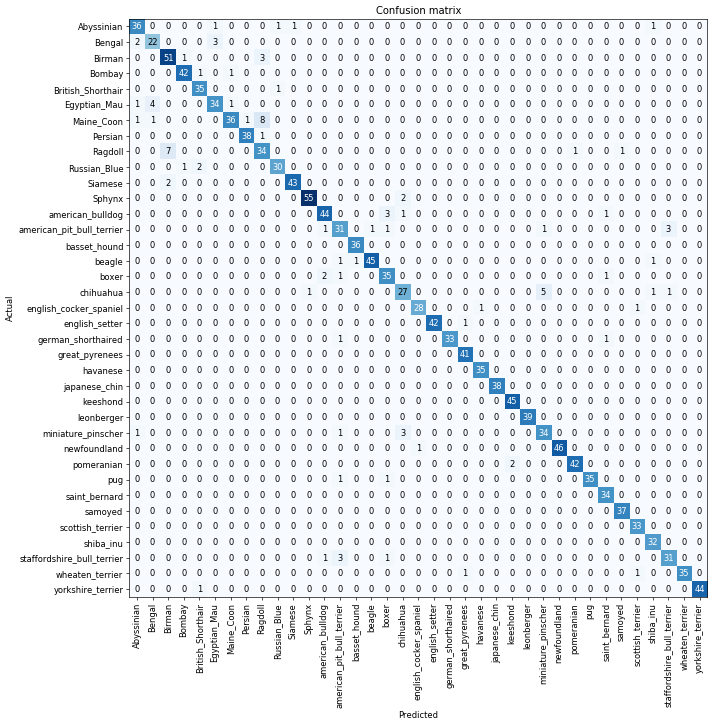

In [23]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [24]:
interp.most_confused(min_val=2)

[('Maine_Coon', 'Ragdoll', 8),
 ('Ragdoll', 'Birman', 7),
 ('chihuahua', 'miniature_pinscher', 5),
 ('Egyptian_Mau', 'Bengal', 4),
 ('Bengal', 'Egyptian_Mau', 3),
 ('Birman', 'Ragdoll', 3),
 ('american_bulldog', 'boxer', 3),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 3),
 ('miniature_pinscher', 'chihuahua', 3),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 3),
 ('Bengal', 'Abyssinian', 2),
 ('Russian_Blue', 'British_Shorthair', 2),
 ('Siamese', 'Birman', 2),
 ('Sphynx', 'chihuahua', 2),
 ('boxer', 'american_bulldog', 2),
 ('pomeranian', 'keeshond', 2)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

우리의 모델이 우리가 기대한 대로 작동하고 있기 때문에, 우리는 우리의 모델을 *unfreeze* 하고 좀 더 학습시킬 겁니다.

In [25]:
learn.unfreeze()

In [26]:
learn.fit_one_cycle(1)

In [27]:
learn.load('stage-1');

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


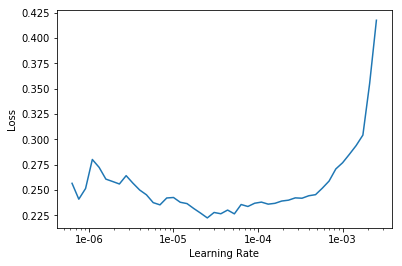

In [29]:
learn.recorder.plot()

In [31]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

That's a pretty accurate model!

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

우리는 전과 같은 방식이지만 한가지 변경사항을 가지고 학습할 것입니다. 앞서 사용했던 resnet34 대신에 resnet50을 backbone으로 사용할 것입니다. (resnet34는 34 layer resudual network이며, resnet50은 50 layer입니다.)

기본적으로 resnet50은 더 깊은 네트워크로 인해 더 많은 파라미터들을 갖고 있기때문에 더 좋은 성능을 냅니다. 
더 높은 성능을 내는지 한 번 확인해 보겠습니다. 그리고 이미지 크기도 좀 더 키워봄으로써 네트워크가 더 많은 디테일을 볼 수 있도록 하겠습니다. 우리는 batch size를 줄이겠습니다. 왜냐하면 더 큰 네트워크는 더 많은 GPU 메모리를 요구하기 때문입니다.

In [11]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [12]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


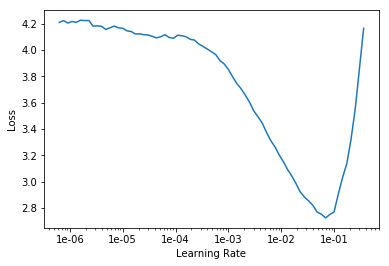

In [18]:
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(8)

In [20]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

애완동물의 품종을 이렇게 정확하게 인식하는 것이 가능하다는 것은 놀라운 일입니다!
full fine-tuning이 도움이 되는지 봅시다.

In [21]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

If it doesn't, you can always go back to your previous model.

만약 도움이 안된다면 전 모델로 돌아가면 됩니다.

In [13]:
learn.load('stage-1-50');

In [23]:
interp = ClassificationInterpretation.from_learner(learn)

In [24]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 6),
 ('american_bulldog', 'staffordshire_bull_terrier', 5),
 ('Ragdoll', 'Birman', 4),
 ('Bengal', 'Egyptian_Mau', 3),
 ('american_pit_bull_terrier', 'american_bulldog', 3),
 ('Egyptian_Mau', 'Bengal', 2),
 ('Russian_Blue', 'Abyssinian', 2),
 ('Russian_Blue', 'Bombay', 2),
 ('Russian_Blue', 'British_Shorthair', 2),
 ('Siamese', 'Birman', 2),
 ('american_bulldog', 'boxer', 2),
 ('boxer', 'american_bulldog', 2),
 ('chihuahua', 'miniature_pinscher', 2),
 ('miniature_pinscher', 'american_pit_bull_terrier', 2),
 ('staffordshire_bull_terrier', 'american_bulldog', 2)]

In [15]:
ys,y = learn.TTA()
accuracy(ys, y)

tensor(0.9438)

## Other data formats

In [41]:
path = untar_data(URLs.MNIST_SAMPLE); path

PosixPath('/home/fastai/.fastai/data/mnist_sample')

In [42]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

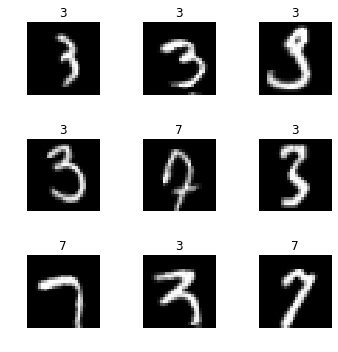

In [43]:
data.show_batch(rows=3, figsize=(5,5))

In [44]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

In [45]:
df = pd.read_csv(path/'labels.csv')
df.head()

name  label
0   train/3/7463.png      0
1  train/3/21102.png      0
2  train/3/31559.png      0
3  train/3/46882.png      0
4  train/3/26209.png      0

In [46]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

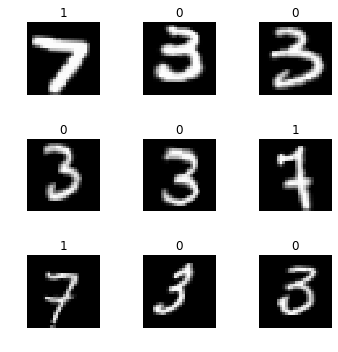

In [47]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [48]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

In [49]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/home/fastai/.fastai/data/mnist_sample/train/3/7463.png'),
 PosixPath('/home/fastai/.fastai/data/mnist_sample/train/3/21102.png')]

In [50]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

In [51]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

In [52]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [53]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']